In [24]:
import tables, glob, os, time, sys
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.colors as colors
from scipy.stats import norm

from stl import mesh
from mpl_toolkits import mplot3d
import scipy.constants as con

In [25]:
def ReadFile(Keys, File): 
    if not os.path.isfile(File):
        print('no')
        return
    else: 
        Data = {}
        try:
            with tables.open_file(File, mode="r") as f: 
                for Key in Keys:    
                    data = f.root._f_get_child(Key)._f_get_child(Key).read()
                    if data is None:
                        print(data)
                    Data[Key] = data
            if Data is None: 
                print(Data)
            return(Data)
        except:
            return 

In [26]:
def GetPhotonFlags(Flags):
    PhotonFlags = {}
    PhotonFlags['NO_HIT'] = (Flags & (0x1 << 0)).astype(bool)   
    PhotonFlags['BULK_ABSORB'] = (Flags & (0x1 << 1)).astype(bool)   
    PhotonFlags['SURFACE_DETECT'] = (Flags & (0x1 << 2)).astype(bool)   
    PhotonFlags['SURFACE_ABSORB'] = (Flags & (0x1 << 3)).astype(bool)   
    PhotonFlags['RAYLEIGH_SCATTER'] = (Flags & (0x1 << 4)).astype(bool)   
    PhotonFlags['REFLECT_DIFFUSE'] = (Flags & (0x1 << 5)).astype(bool)   
    PhotonFlags['REFLECT_SPECULAR'] = (Flags & (0x1 << 6)).astype(bool)    
    PhotonFlags['SURFACE_REEMIT'] = (Flags & (0x1 << 7)).astype(bool)    
    PhotonFlags['SURFACE_TRANSMIT'] = (Flags & (0x1 << 8)).astype(bool)    
    PhotonFlags['BULK_REEMIT'] = (Flags & (0x1 << 9)).astype(bool)   
    PhotonFlags['MATERIAL_REFL'] = (Flags & (0x1 << 10)).astype(bool)  
    PhotonFlags['NAN_ABORT'] = (Flags & (0x1 << 31)).astype(bool)  
    return PhotonFlags

In [27]:
allKeys = ['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 
                  'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 
                  'PhotonWavelength', 'PhotonTime', 'DetectorHit']

# Keys1 = ['Origin', 'LastHitTriangle', 'IncidentAngles', 'DetectorHit', 'Flags', 'FinalPosition', 'NumDetected', 
#          'InitialPosition', 'DetectedPos', 'PhotonWavelength']

#10 muons, 70 PMTs, QE on - trying to get channel hit time
File1 = "h5_files/chroma_nEXO_OD_OD_70PMT_QE_210719_143945_r1707.h5"
#same but with photonTime variables
File1 = "h5_files/chroma_nEXO_OD_OD_70PMT_QE_210719_163329_r1658.h5"

Data1 = ReadFile(allKeys, File1)

In [28]:
print(Data1.keys())

# for var in Data1.keys():
#     print(var, "- number of entries:", len(Data1[var]))
#     print("     ", Data1[var], '\n')

dict_keys(['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 'PhotonWavelength', 'PhotonTime', 'DetectorHit'])


## Looking at photon paths

In [29]:
I_pos = Data1['InitialPosition'].T
f_pos = Data1['FinalPosition'].T  
d_pos = Data1['DetectedPos'].T  

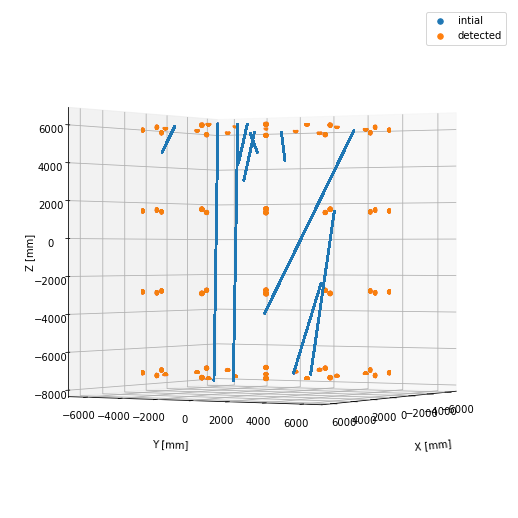

In [30]:
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(I_pos[0], I_pos[1], I_pos[2], 'blue', label='intial', s=0.9)
# axes.scatter3D(f_pos[0], f_pos[1], f_pos[2], 'red', alpha=0.1, s=0.6, label='final')

axes.scatter3D(d_pos[0], d_pos[1], d_pos[2], 'orange', alpha=0.1, s=0.6, label='detected')

# axes.set_xlim3d(-6000, 6000)
# axes.set_ylim3d(-6000, 6000)
# axes.set_zlim3d(-7800, +6730)

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

lgnd = axes.legend()

#change the marker size manually for both lines
for L in lgnd.legendHandles:
    L._sizes = [30]
    L.set_alpha(1)
    
#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 30)

# 0, 90 - XZ plane; 90, 90 - top view

plt.show()

## Looking at PMTs with Channel data

In [31]:
print(Data1.keys())

print(Data1['NumDetected'])
print(np.sum(Data1['NumDetected']))

dict_keys(['NumDetected', 'ChannelCharges', 'ChannelIDs', 'NumHitChannels', 'IncidentAngles', 'Flags', 'LastHitTriangle', 'FinalPosition', 'InitialPosition', 'DetectedPos', 'PhotonWavelength', 'PhotonTime', 'DetectorHit'])
[ 1606 12042  6314  2232  7939  1279  2777  1764 10522  4741]
51216


In [32]:
#for each photoh hit, records which PMT is hit
ChannelIDs = Data1['ChannelIDs']
print(len(ChannelIDs))

#total number of channels hit for each muon (so max here is the total number of PMTs used)
NumHitChannels = Data1['NumHitChannels']
print(np.sum(Data1['NumHitChannels']))
# ChannelIDs

698
698


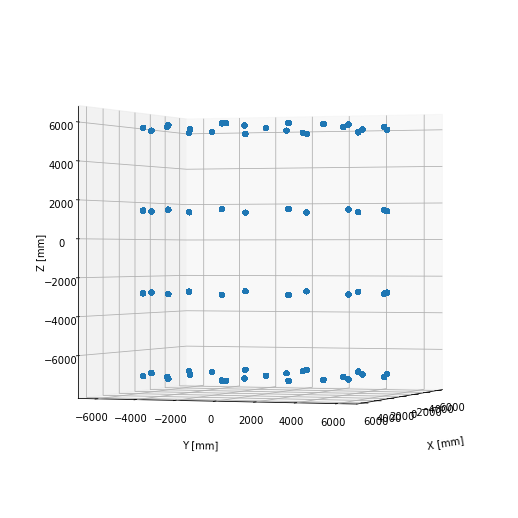

In [33]:
PMTHit_pos = Data1['DetectorHit'].T
fig = plt.figure(figsize=(7,7))
axes = mplot3d.Axes3D(fig)

axes.scatter3D(PMTHit_pos[0], PMTHit_pos[1], PMTHit_pos[2], 'blue')

axes.set_xlabel("X [mm]")
axes.set_ylabel("Y [mm]")
axes.set_zlabel("Z [mm]")
axes.xaxis.labelpad=20
axes.yaxis.labelpad=15
# axes.zaxis.labelpad=15

#change angle of view - (elevation, azimuth) angles in degrees
# ‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
axes.view_init(0, 20)

# 0, 90 - XZ plane; 90, 90 - top views

plt.show()

In [46]:
PhotonFlags_flip = GetPhotonFlags(Data1['Flags'])
HitTimes_detect = HitTimes[PhotonFlags_flip['SURFACE_DETECT']]

print(len(PMTHit_pos[0]), len(HitTimes), len(HitTimes_detect))


51216 2394861 51216


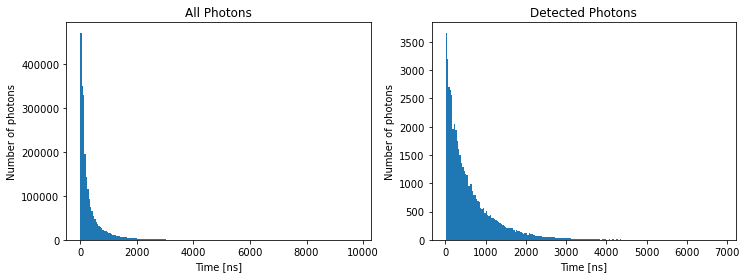

In [ ]:
#all photon wavelengths
# HitTimes = Data1['ChannelTimes'] 
HitTimes = Data1['PhotonTime'] 

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

axs[0].hist(HitTimes, bins=200)
axs[0].set_xlabel("Time [ns]")
axs[0].set_ylabel("Number of photons")
axs[0].set_title("All Photons")

axs[1].hist(HitTimes_detect, bins=200)
axs[1].set_xlabel("Time [ns]")
axs[1].set_ylabel("Number of photons")
axs[1].set_title("Detected Photons")
plt.show() 

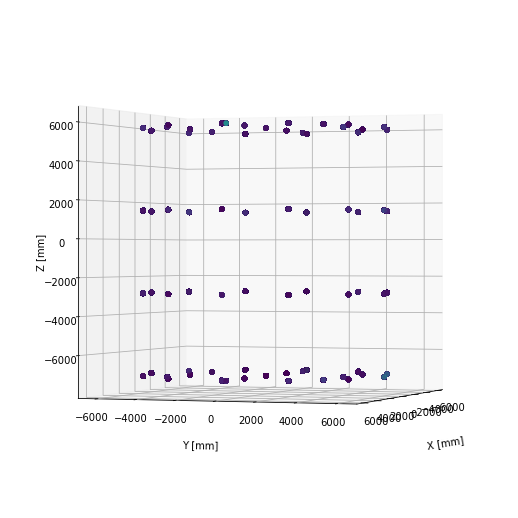